In [1]:
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt

from lib import (
    FinnDir,
    load_exp_data,
    load_exp_conf,
    solve_diffusion_sorption_pde,
    interp1D_torch,
    FinnParams,
    compute_core2B_profile,
    finn_fit_retardation
)

In [2]:
finn_out_path = Path("../data_out/finn/")

# Core 2

## Training

In [3]:
data_core2_df = load_exp_data(name="Core 2")
conf_core2 = load_exp_conf(name="Core 2")

data_core2b_df = load_exp_data(name="Core 2B")
conf_core2b = load_exp_conf(name="Core 2B")

In [4]:
finn_core2_dir = FinnDir(finn_out_path / "core2")
# is_ok_to_delete = input(f"Remove {finn_core2_dir.path} (y/n)? ")
# if is_ok_to_delete == "y":
# shutil.rmtree(finn_core2_dir.path.absolute())
# finn_core2_dir = FinnDir(finn_root / "core2")
np.save(finn_core2_dir.c_train_path, data_core2_df["c_diss"])
np.save(finn_core2_dir.t_train_path, data_core2_df["time"])
finn_fit_retardation(
    out_dir=finn_core2_dir.path,
    is_exp_data=True,
    n_epochs=21,
    **conf_core2,
)

## Analysis

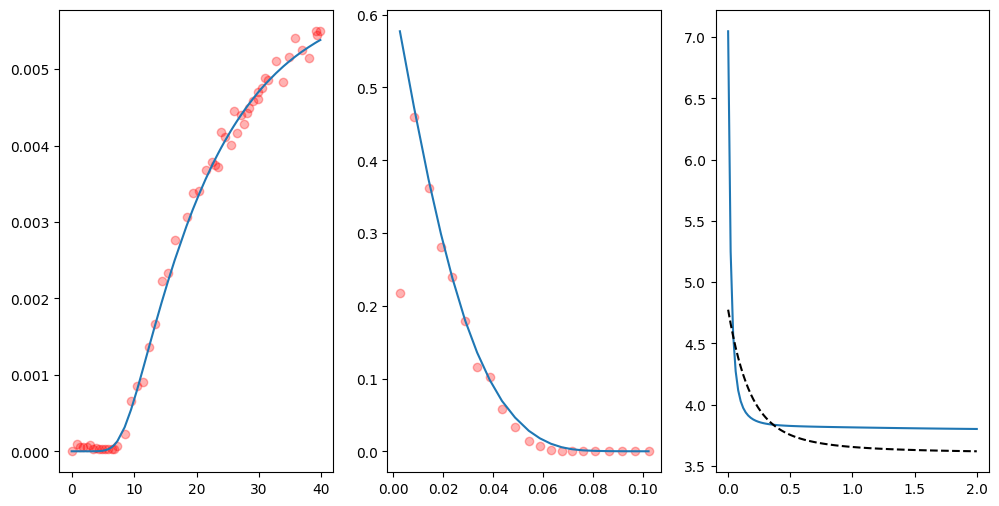

In [5]:
core2b_pred = compute_core2B_profile(finn_core2_dir)

u = np.load(finn_core2_dir.u_ret_path)

n_epochs = finn_core2_dir.n_epochs
fig, axs = plt.subplots(ncols=3, figsize=(12, 6))

axs[0].scatter(data_core2_df["time"], data_core2_df["c_diss"], color="red", alpha=0.3)
axs[0].plot(
    data_core2_df["time"], np.load(finn_core2_dir.get_data_pred_path(n_epochs-1)), zorder=10
)

axs[1].scatter(data_core2b_df["x"], data_core2b_df["c_tot"], color="red", alpha=0.3)
axs[1].plot(data_core2b_df["x"], core2b_pred, zorder=10)

axs[2].plot(*finn_core2_dir.best_ret_points)
axs[2].plot(u, np.load("/Users/r/Documents/dev/tmp/finn_with_julia/python/diffusion_sorption/experimental_data/learned_retardation.npy"), "k--")
plt.show()

# P3INN on Core 2 Data

In [6]:
finn_root = finn_out_path / "p3inn_core2_new"
finn_dirs = list(map(FinnDir, finn_root.iterdir()))

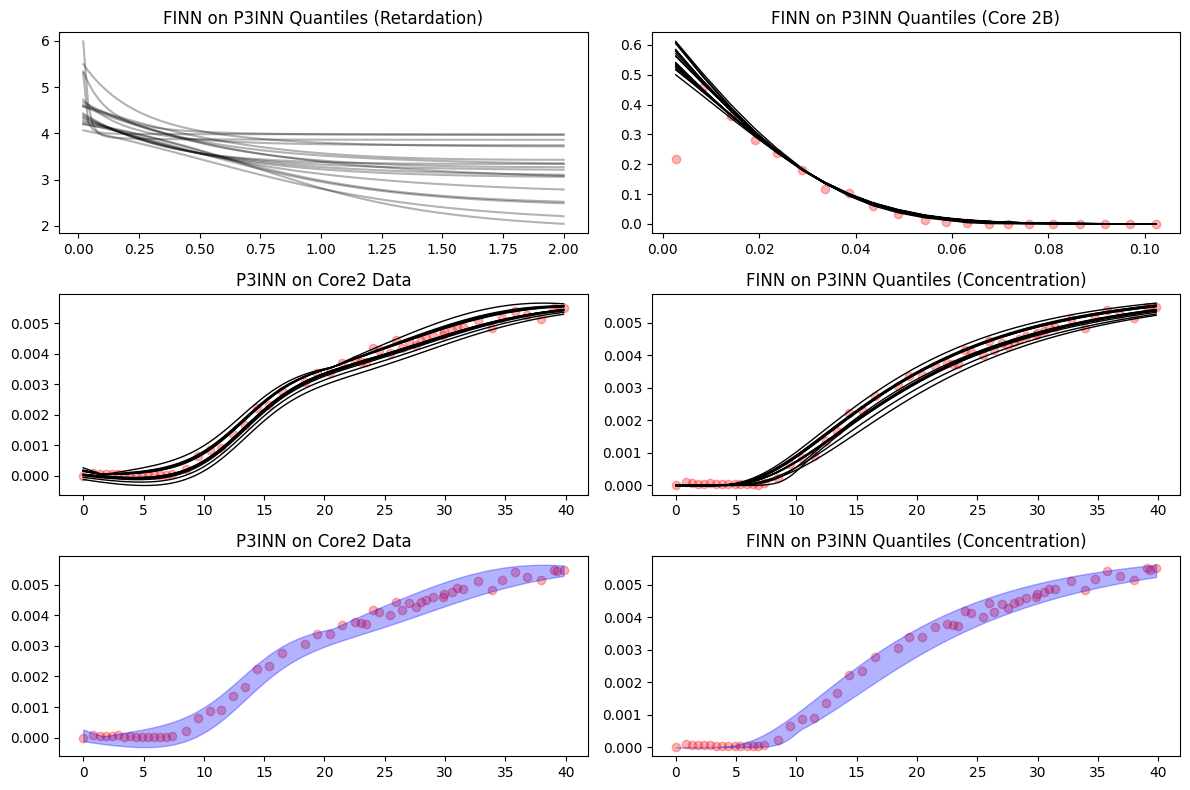

In [7]:
data_core2_df = load_exp_data("Core 2")
data_core2b_df = load_exp_data("Core 2B")

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

data_kwargs = {"color": "red", "label": "Core2 Data", "alpha": 0.3, "edgecolor": None}
t_data = data_core2_df["time"]
axs[0, 1].scatter(data_core2b_df["x"], data_core2b_df["c_tot"], **data_kwargs)
axs[1, 0].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)
axs[1, 1].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)

all_c_profiles_p3inn = []
all_c_profiles_finn = []

for finn_dir in finn_dirs:
    try:
        u_ret = np.load(finn_dir.u_ret_path)
        loss = np.load(finn_dir.loss_path)
        best_epoch = finn_dir.best_epoch
        ret = np.load(finn_dir.get_pred_ret_path(best_epoch))
        pred_data = np.load(finn_dir.get_data_pred_path(best_epoch))
        data = np.load(finn_dir.c_train_path)
    except FileNotFoundError as e:
        print(e)
        continue

    pred_kwargs = {"color": "black", "zorder": 1, "alpha": 1.0, "lw": 1.0}
    if np.any(ret < 1) or np.any(ret > 100):
        print("Skipping", finn_dir)
        pred_kwargs["color"] = "red"
        pred_kwargs["zorder"] = 10
        pred_kwargs["lw"] = 3
        continue
    
    all_c_profiles_p3inn.append(data)
    all_c_profiles_finn.append(pred_data)


    core2b_c = compute_core2B_profile(finn_dir)
    t_eval = np.linspace(t_data.min(), t_data.max(), len(data))

    axs[0, 0].set_title("FINN on P3INN Quantiles (Retardation)")
    axs[0, 0].plot(u_ret[1:], ret[1:], "k-", alpha=0.3)

    axs[0, 1].set_title("FINN on P3INN Quantiles (Core 2B)")
    axs[0, 1].plot(data_core2b_df["x"], core2b_c, "-", **pred_kwargs)

    axs[1, 0].set_title("P3INN on Core2 Data")
    axs[1, 0].plot(t_eval, data, "-", **pred_kwargs)

    axs[1, 1].set_title("FINN on P3INN Quantiles (Concentration)")
    axs[1, 1].plot(t_eval, pred_data, "-", **pred_kwargs)

bound_upper_p3inn = np.max(all_c_profiles_p3inn, axis=0)
bound_lower_p3inn = np.min(all_c_profiles_p3inn, axis=0)
bound_upper_finn = np.max(all_c_profiles_finn, axis=0)
bound_lower_finn = np.min(all_c_profiles_finn, axis=0)

pi_kwargs = dict(color="blue", alpha=0.3, zorder=10)
axs[2, 0].set_title("P3INN on Core2 Data")
axs[2, 0].fill_between(t_eval, bound_lower_p3inn, bound_upper_p3inn, **pi_kwargs)
axs[2, 0].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)

axs[2, 1].set_title("FINN on P3INN Quantiles (Concentration)")
axs[2, 1].fill_between(t_eval, bound_lower_finn, bound_upper_finn, **pi_kwargs)
axs[2, 1].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)

plt.tight_layout()
plt.show()

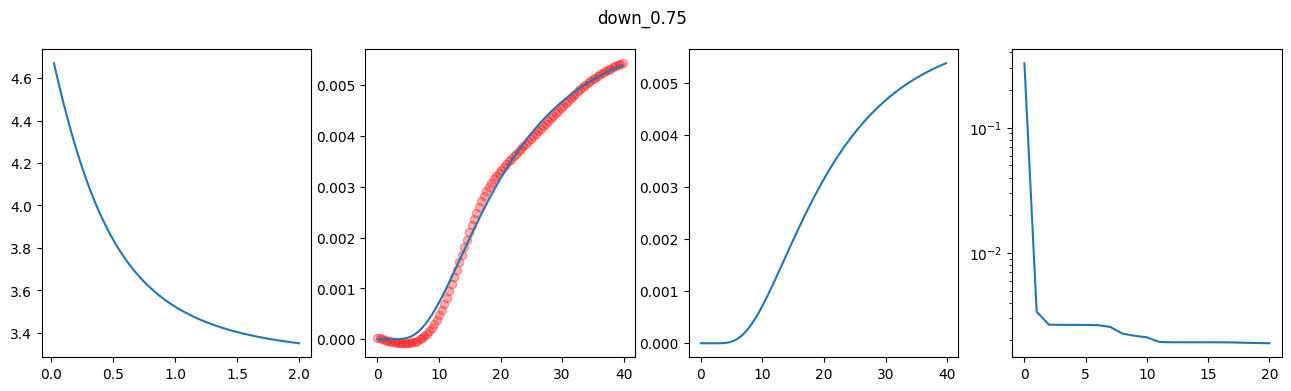

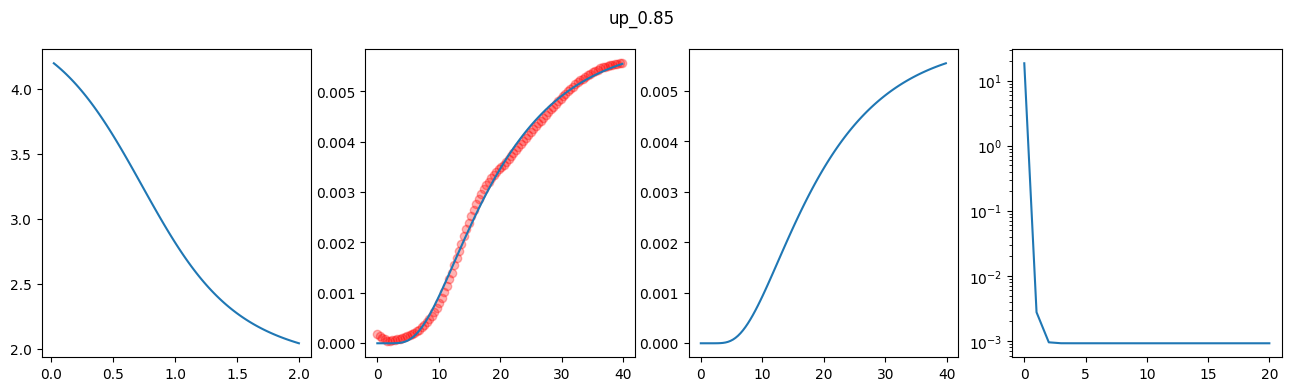

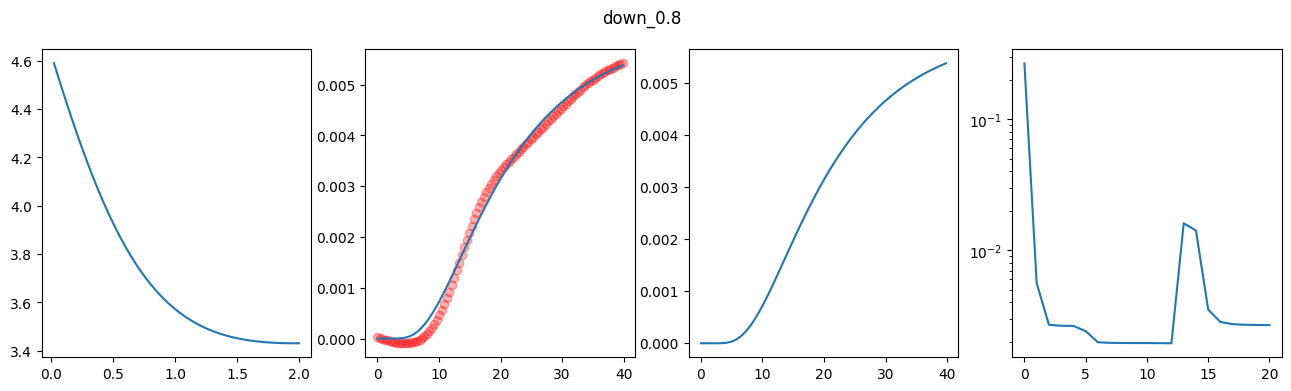

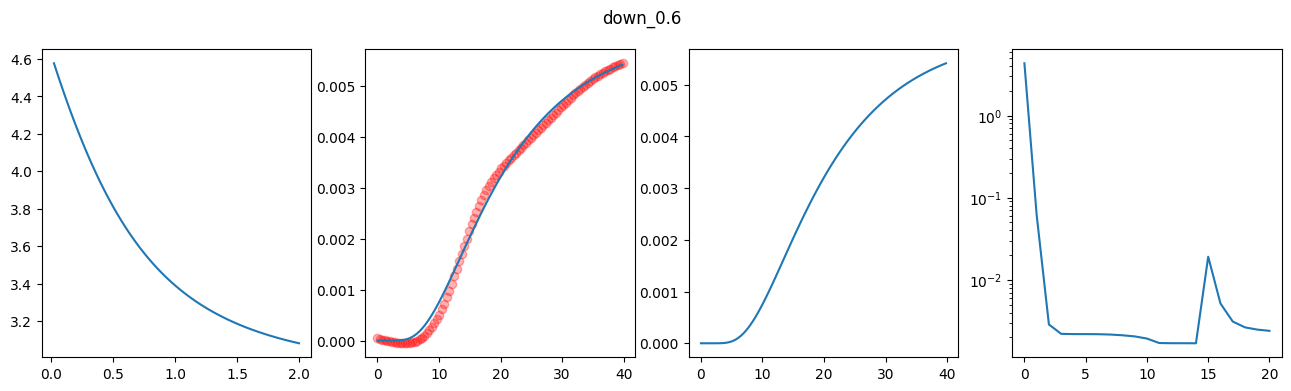

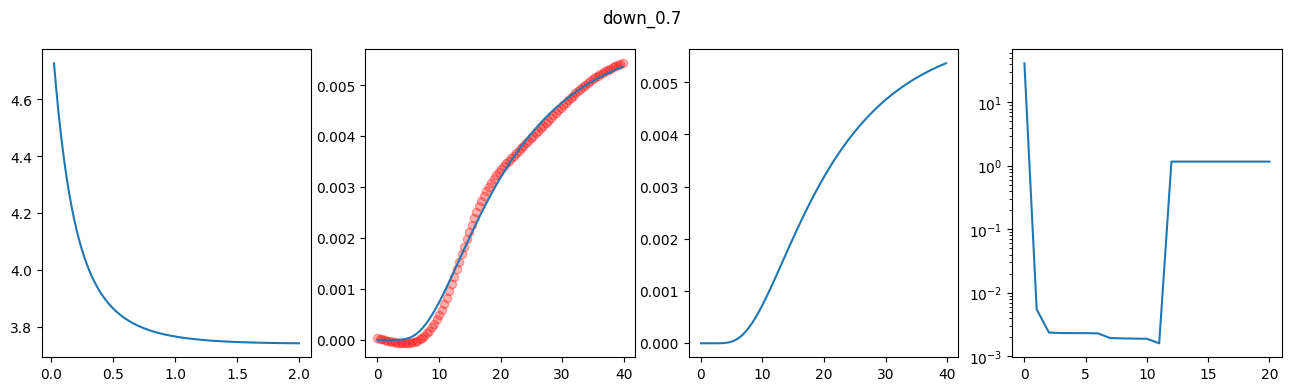

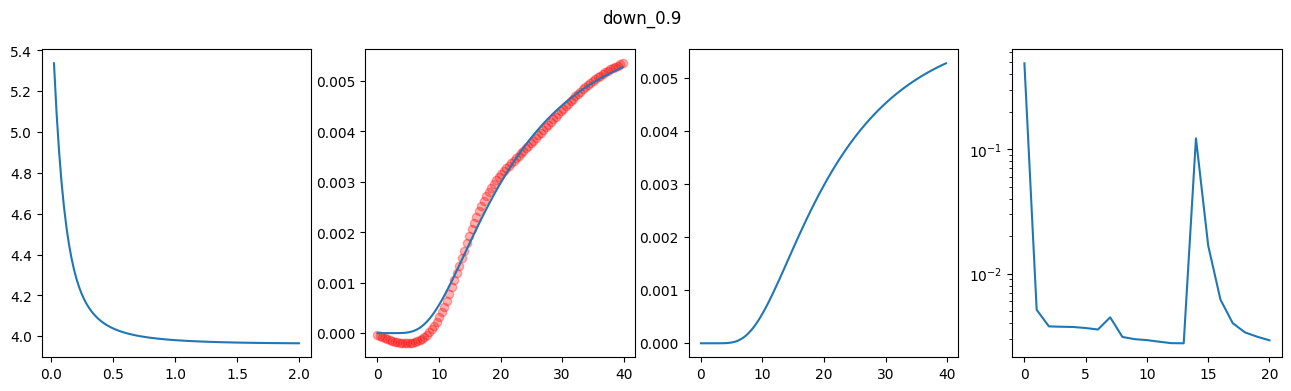

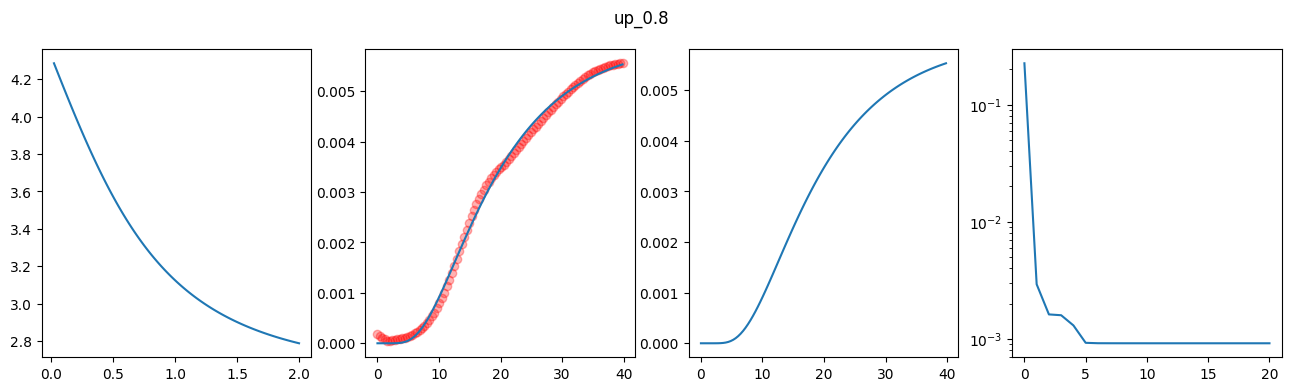

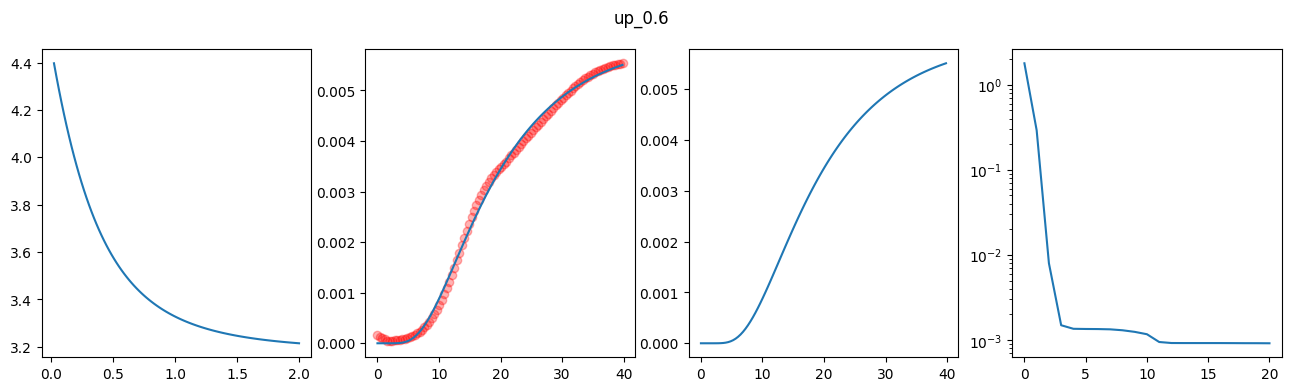

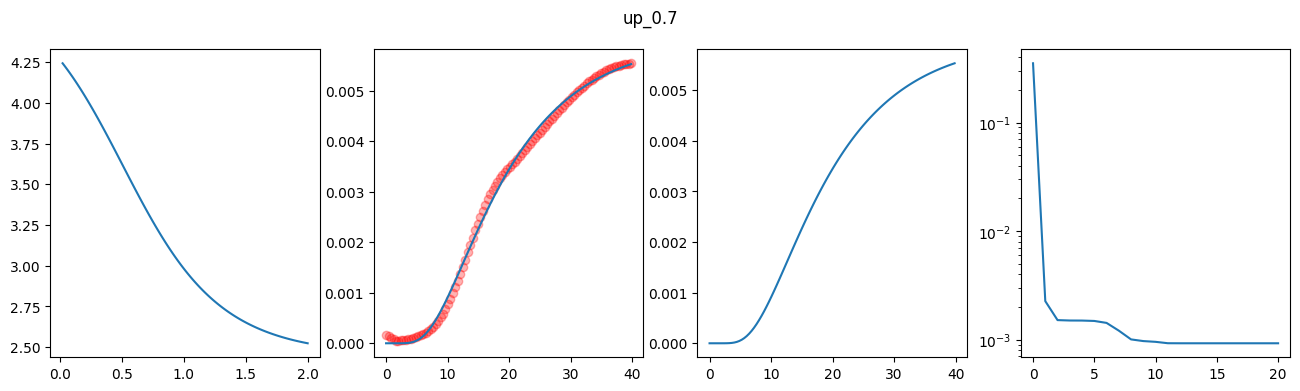

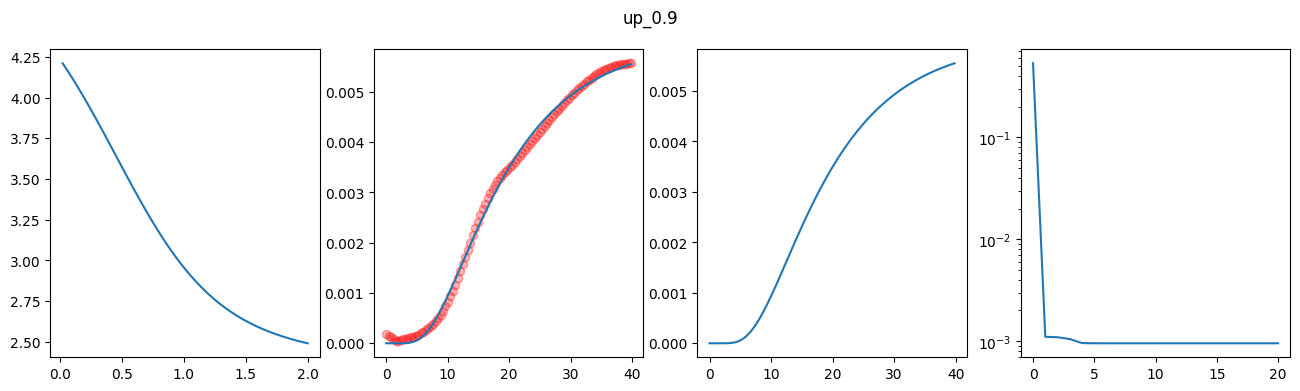

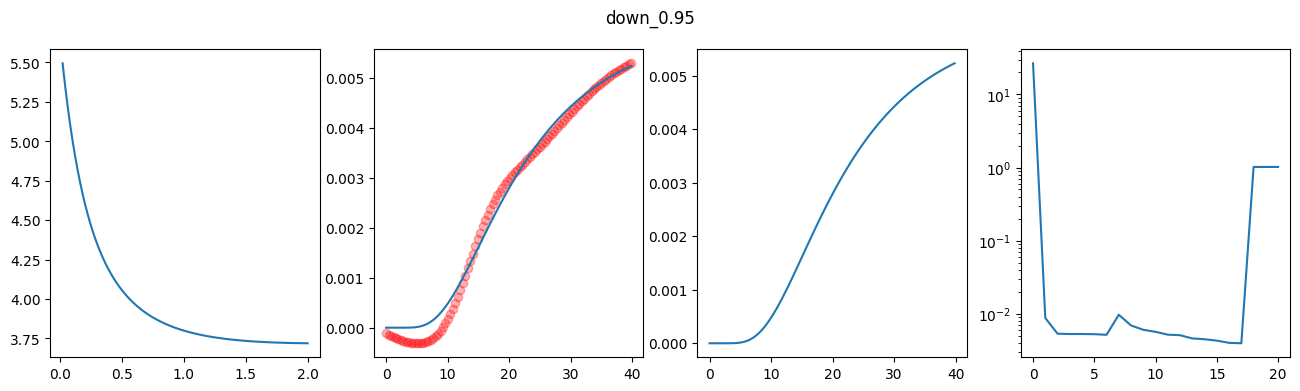

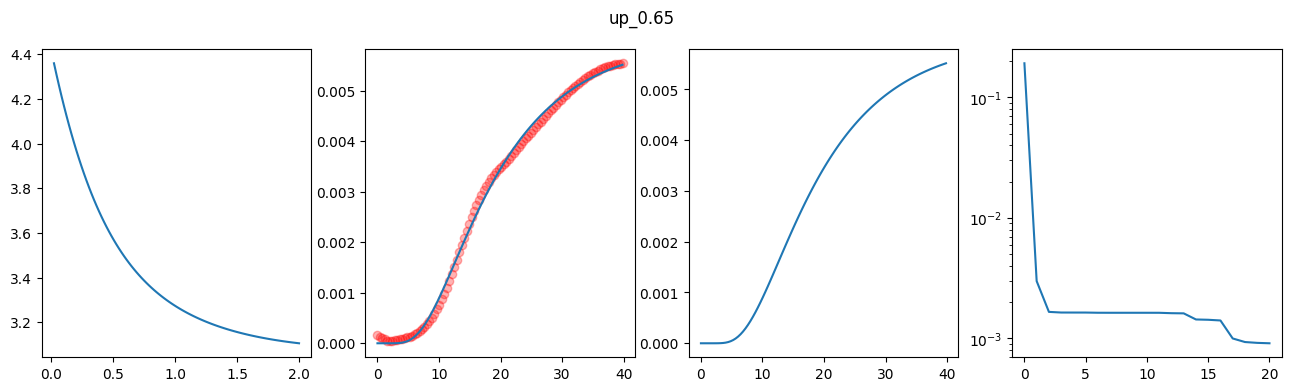

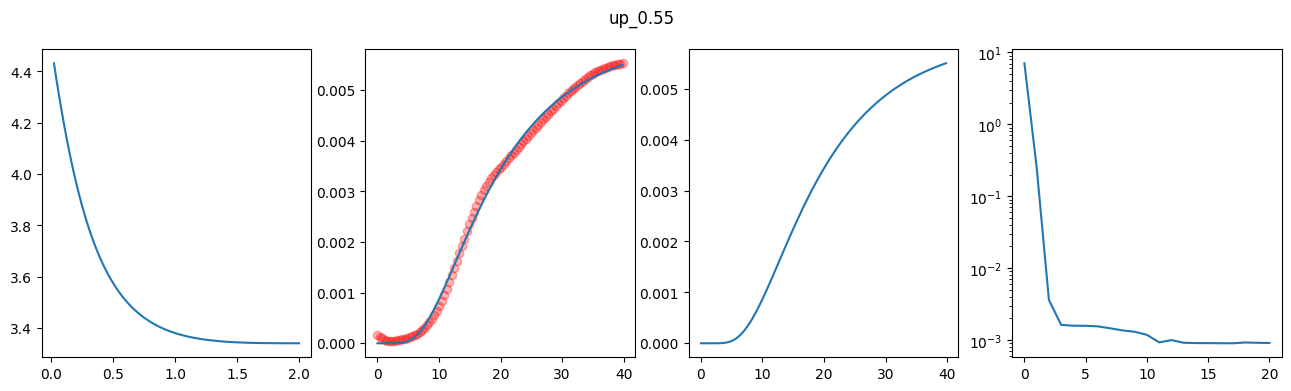

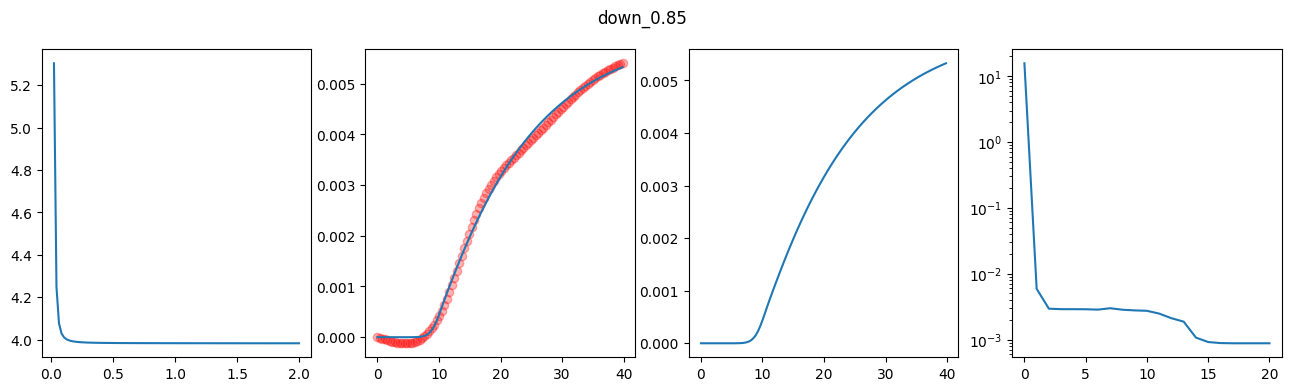

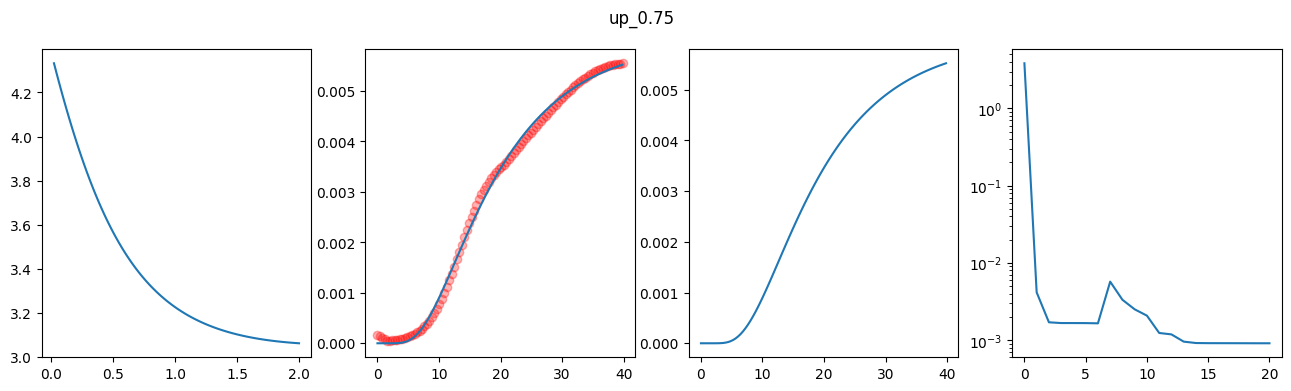

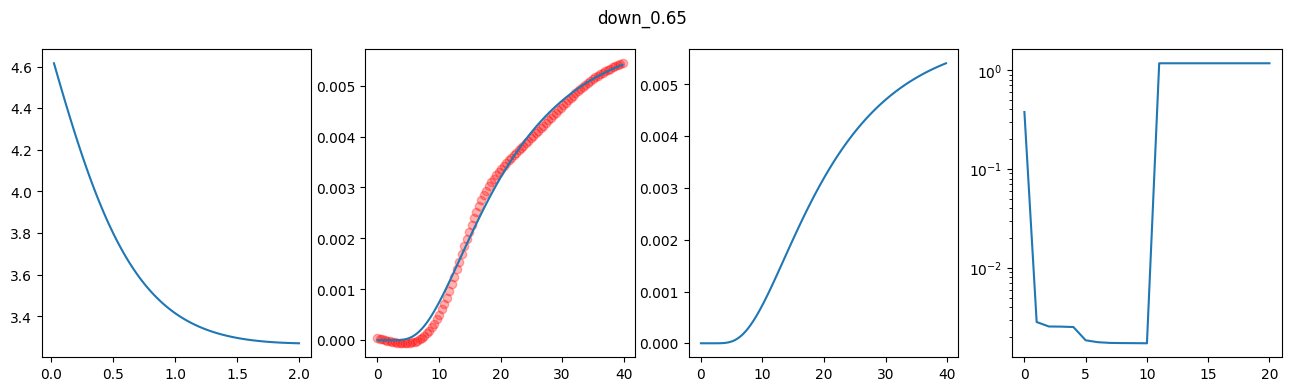

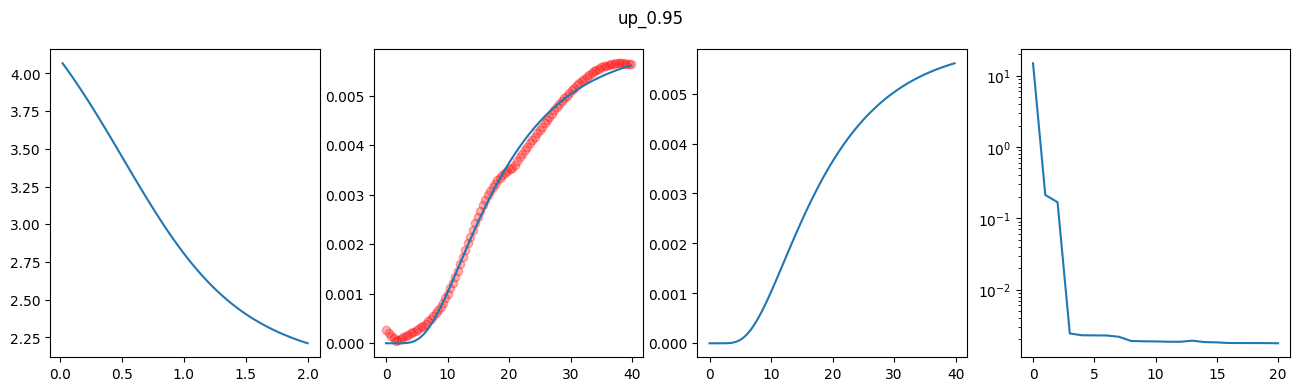

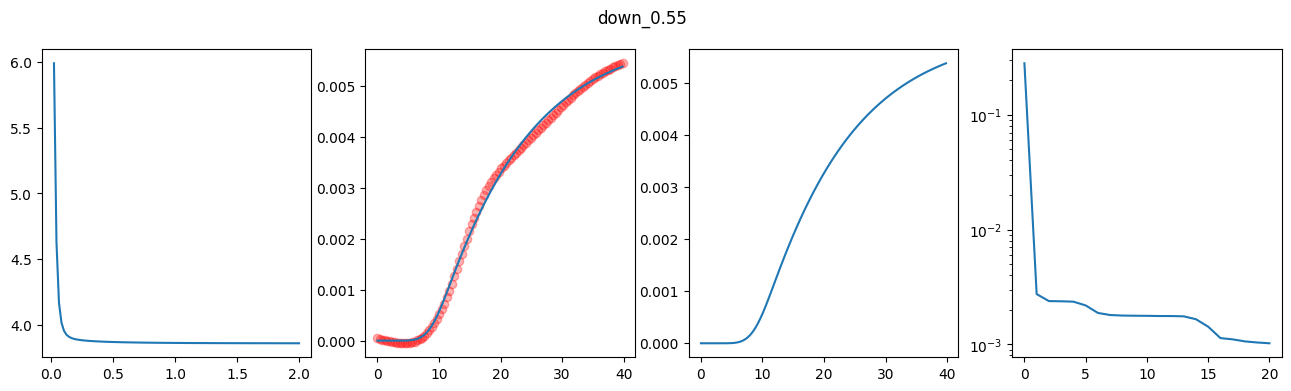

In [8]:
for finn_dir in finn_dirs:
    try:
        u_ret = np.load(finn_dir.u_ret_path)
        loss = np.load(finn_dir.loss_path)
        best_epoch = finn_dir.best_epoch
        ret = np.load(finn_dir.get_pred_ret_path(best_epoch))
        pred_data = np.load(finn_dir.get_data_pred_path(best_epoch))
        data = np.load(finn_dir.c_train_path)
    except FileNotFoundError as e:
        print(e)
        continue

    fig, axs = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle(f"{finn_dir.path.name}")
    axs[0].plot(u_ret[1:], ret[1:])
    axs[1].scatter(t_eval, data, **data_kwargs)
    axs[1].plot(t_eval, pred_data, "-")
    axs[2].plot(t_eval, pred_data, "-")
    axs[3].semilogy(loss, "-")
    plt.show()